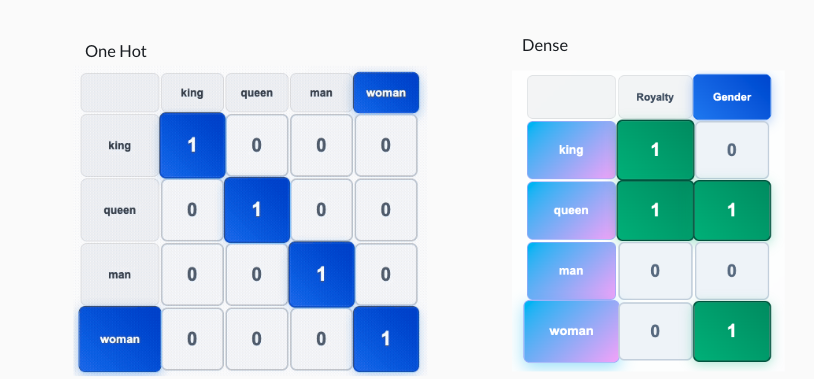

In [18]:
!head -n 4 train.jsonl

{"id":"cb774db0d1","text":" I`d have responded, if I were going","label":1,"label_text":"neutral"}
{"id":"549e992a42","text":" Sooo SAD I will miss you here in San Diego!!!","label":0,"label_text":"negative"}
{"id":"088c60f138","text":"my boss is bullying me...","label":0,"label_text":"negative"}
{"id":"9642c003ef","text":" what interview! leave me alone","label":0,"label_text":"negative"}


# BPE tokenizer 

-- uses utf- 8 

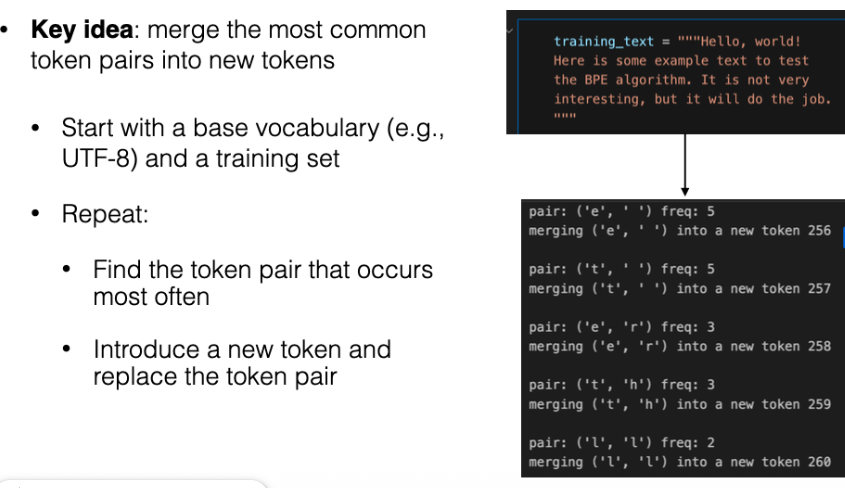

In [19]:
import sentencepiece as spm
import json
import os

with open("bow_tokenizer_txt.txt", "w", encoding="utf-8") as f:
    with open('train.jsonl',"r") as f2:
        for line in f2:
            j = json.loads(line)
            words = j['text']
            f.write(words + "\n")

options = dict(
    input = "bow_tokenizer_txt.txt",
    input_format= "text",
    model_prefix="bow_tok",
    model_type="bpe",
    vocab_size=2048,
    byte_fallback=True,
    num_threads=os.cpu_count()
)

spm.SentencePieceTrainer.train(**options)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: bow_tokenizer_txt.txt
  input_format: text
  model_prefix: bow_tok
  model_type: BPE
  vocab_size: 2048
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 10
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 1
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0

In [20]:
sp = spm.SentencePieceProcessor()
sp.load('bow_tok.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab[1000:1020]

[['get', 1000],
 ['▁gl', 1001],
 ['▁away', 1002],
 ['eeee', 1003],
 ['▁left', 1004],
 ['▁mothers', 1005],
 ['?!', 1006],
 ['ily', 1007],
 ['oke', 1008],
 ['url', 1009],
 ['▁late', 1010],
 ['ire', 1011],
 ['hes', 1012],
 ['ner', 1013],
 ['▁Hope', 1014],
 ['▁Twitter', 1015],
 ['▁sha', 1016],
 ['▁bu', 1017],
 ['▁em', 1018],
 ['inking', 1019]]

In [21]:
from collections import defaultdict
import random

random.seed(123)

label_to_text = {}
def read_dataset(filename):
    with open(filename, "r") as f:
        for line in f:
            j = json.loads(line)
            words = j['text']
            label = j['label']
            label_to_text[label] = j['label_text']
            tokens = sp.encode(words)
            yield (tokens, label)

ds = list(read_dataset("train.jsonl"))
random.shuffle(ds)
train = ds[:-1000]
dev = ds[1000:]

nwords = len(sp) #vocab_size
ntags= 3 #output classes

# Rule based model - bag of words

- counting positive/negative words
- not define what is a good/bad word
- train our model so that it understands whether the word is good/bad based on its supervised training data

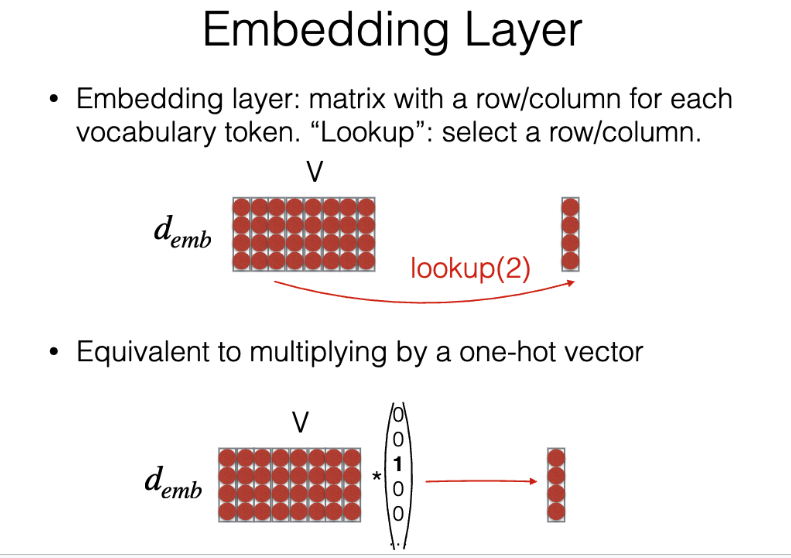

In [22]:
import torch

print(train[1][0][:5])

#conver this into one hot vector

xs = torch.nn.functional.one_hot(torch.tensor(train[1][0]), num_classes=nwords)[:5]

[402, 510, 953, 428, 413]


In [23]:
xs

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [24]:
import torch.nn as nn

weight = nn.Parameter(torch.randn(nwords, 64))  #vocab_size, embedding dimension
weight

Parameter containing:
tensor([[-1.0055,  0.7963, -1.1211,  ...,  1.0399, -1.3078, -1.1341],
        [ 0.5067, -0.4046,  1.9584,  ..., -2.4510, -0.7935,  0.5755],
        [ 0.1014,  1.7767,  0.1534,  ...,  0.9463, -0.6598, -0.4531],
        ...,
        [ 0.4494,  1.2813,  0.7726,  ..., -0.5569, -1.7896, -0.5471],
        [-0.0680, -0.8714, -0.3296,  ..., -0.7018, -0.9815, -0.9219],
        [-0.4175,  1.5559, -0.2765,  ...,  0.8582,  0.5667,  0.1392]],
       requires_grad=True)

In [25]:
torch.matmul(xs.float(), weight).shape

torch.Size([5, 64])

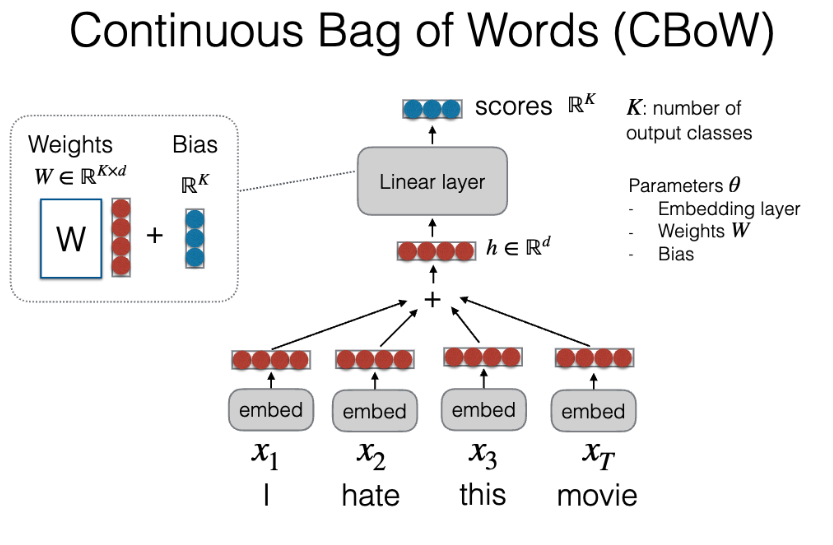

In [26]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(Embedding, self).__init__() # super allows you to initialise the nn.Module
        self.weight = nn.Parameter(torch.randn(vocab_size, emb_size))
        self.vocab_size = vocab_size
        
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        xs = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        return torch.matmul(xs, self.weight)
    

In [27]:
class BoW(torch.nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(BoW, self).__init__() # super allows you to initialise the nn.Module
        self.embedding = Embedding(vocab_size, num_labels)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, tokens):
        emb = self.embedding(tokens)
        out = torch.sum(emb, dim=0)
        logits = out.view(1,-1)
        return logits

sad = [3, 5, 2]


actual sad = [0, 1, 0]

Binary_classification

output - Probability - [0.1, 0.9]

# we have to ensure output is between 0 and 1 
sigmoid


In [30]:
def ce_loss(logits, target):
    log_probs = torch.nn.functional.log_softmax(logits, dim=1)
    loss = -log_probs[:,target]
    return loss

In [31]:
import random
import time

# initialize the model
model = BoW(nwords, ntags)
criterion = ce_loss
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for ITER in range(5):
    # Perform training
    random.shuffle(train)
    train_loss = 0.0
    start = time.time()
    for x, y in train:
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor([y])
        logits = model(x)
        loss = criterion(logits, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("iter %r: train loss/sent=%.4f, time=%.2fs" % (
                ITER, train_loss/len(train), time.time()-start))
    # Perform validation
    test_correct = 0.0
    for x, y in dev:
        x = torch.tensor(x, dtype=torch.long)
        logits = model(x)[0].detach()
        predict = logits.argmax().item()
        if predict == y:
            test_correct += 1
    print("iter %r: valid acc=%.4f" % (ITER, test_correct/len(dev)))

iter 0: train loss/sent=0.9027, time=3.58s
iter 0: valid acc=0.6862
iter 1: train loss/sent=0.7724, time=3.51s
iter 1: valid acc=0.7023
iter 2: train loss/sent=0.7376, time=3.45s
iter 2: valid acc=0.7115
iter 3: train loss/sent=0.7222, time=3.42s
iter 3: valid acc=0.7130
iter 4: train loss/sent=0.7142, time=3.44s
iter 4: valid acc=0.7126


y = wx + b

In [34]:
class CBoW(torch.nn.Module):
    def __init__(self, vocab_size, emb_size, num_labels):
        super(CBoW, self).__init__() # super allows you to initialise the nn.Module
        self.embedding = Embedding(vocab_size, emb_size)
        self.output_layer = nn.Linear(emb_size, num_labels)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, tokens):
        emb = self.embedding(tokens)
        out = torch.sum(emb, dim=0)
        h = out.view(1,-1)
        logits = self.output_layer(h)
        return logits

In [35]:
import random
import time

EMBED_SIZE = 32
# initialize the model
model = CBoW(nwords, ntags, EMBED_SIZE)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for ITER in range(5):
    # Perform training
    random.shuffle(train)
    train_loss = 0.0
    start = time.time()
    for x, y in train:
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor([y])
        logits = model(x)
        loss = criterion(logits, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("iter %r: train loss/sent=%.4f, time=%.2fs" % (
                ITER, train_loss/len(train), time.time()-start))
    # Perform validation
    test_correct = 0.0
    for x, y in dev:
        x = torch.tensor(x, dtype=torch.long)
        logits = model(x)[0].detach()
        predict = logits.argmax().item()
        if predict == y:
            test_correct += 1
    print("iter %r: valid acc=%.4f" % (ITER, test_correct/len(dev)))

iter 0: train loss/sent=0.9965, time=4.27s
iter 0: valid acc=0.6857
iter 1: train loss/sent=0.7580, time=4.23s
iter 1: valid acc=0.7151
iter 2: train loss/sent=0.7241, time=4.27s
iter 2: valid acc=0.7224
iter 3: train loss/sent=0.7096, time=4.20s
iter 3: valid acc=0.7186
iter 4: train loss/sent=0.7015, time=4.19s
iter 4: valid acc=0.7287


y = wx + b

In [40]:
class DeepCBoW(torch.nn.Module):
    def __init__(self, vocab_size, emb_size, num_labels, hid_size):
        super(DeepCBoW, self).__init__() # super allows you to initialise the nn.Module
        self.embedding = Embedding(vocab_size, emb_size)
        self.linear1 = nn.Linear(emb_size,hid_size)
        self.output_layer = nn.Linear(hid_size, num_labels)
        nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, tokens):
        emb = self.embedding(tokens)
        emb_sum = torch.sum(emb, dim=0)
        h = emb_sum.view(1,-1)
        h = torch.tanh(self.linear1(h))
        logits = self.output_layer(h)
        return logits

In [42]:
import random
import time

EMBED_SIZE = 32
# initialize the model
model = DeepCBoW(nwords, ntags, EMBED_SIZE, 32)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for ITER in range(10):
    # Perform training
    random.shuffle(train)
    train_loss = 0.0
    start = time.time()
    for x, y in train:
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor([y])
        logits = model(x)
        loss = criterion(logits, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("iter %r: train loss/sent=%.4f, time=%.2fs" % (
                ITER, train_loss/len(train), time.time()-start))
    # Perform validation
    test_correct = 0.0
    for x, y in dev:
        x = torch.tensor(x, dtype=torch.long)
        logits = model(x)[0].detach()
        predict = logits.argmax().item()
        if predict == y:
            test_correct += 1
    print("iter %r: valid acc=%.4f" % (ITER, test_correct/len(dev)))

iter 0: train loss/sent=0.8560, time=4.95s
iter 0: valid acc=0.7059
iter 1: train loss/sent=0.6992, time=5.39s
iter 1: valid acc=0.7278
iter 2: train loss/sent=0.6693, time=5.12s
iter 2: valid acc=0.7361
iter 3: train loss/sent=0.6496, time=5.11s
iter 3: valid acc=0.7448
iter 4: train loss/sent=0.6348, time=5.31s
iter 4: valid acc=0.7494
iter 5: train loss/sent=0.6246, time=5.60s
iter 5: valid acc=0.7531
iter 6: train loss/sent=0.6146, time=5.11s
iter 6: valid acc=0.7580
iter 7: train loss/sent=0.6080, time=5.07s
iter 7: valid acc=0.7574
iter 8: train loss/sent=0.6023, time=5.03s
iter 8: valid acc=0.7633
iter 9: train loss/sent=0.5978, time=5.07s
iter 9: valid acc=0.7634


In [43]:
corpus = (
    # Animals
    ["dog cat puppy kitten"] * 30 +
    ["lion tiger leopard"] * 30 +
    ["elephant giraffe zebra"] * 30 +

    # Fruits
    ["apple banana mango"] * 30 +
    ["orange lemon citrus"] * 30 +

    # Vehicles
    ["car bus truck"] * 30 +
    ["bike bicycle cycle"] * 30 +

    # Tech
    ["computer laptop keyboard"] * 30 +
    ["software hardware computer"] * 30 +
    ["python java programming"] * 30
)

In [44]:
tokenized = [s.split() for s in corpus]

In [45]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=tokenized,
    vector_size=64,
    window=5,
    min_count=1,
    sg=1,
    epochs=50,
    workers=1,
)


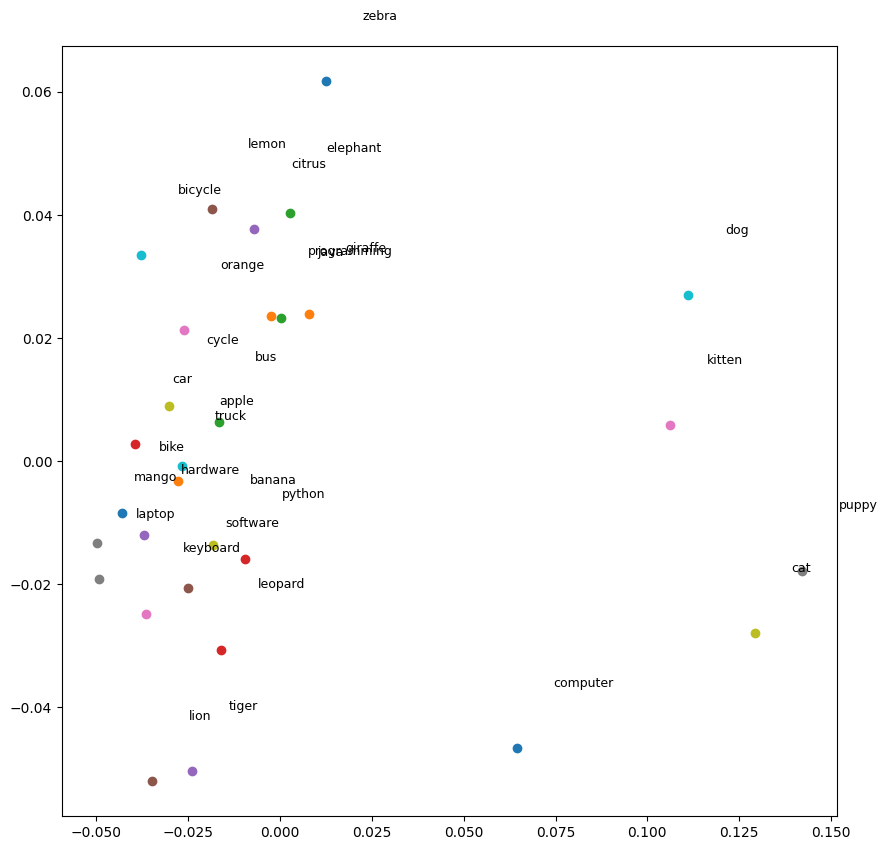

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

words = list(model.wv.index_to_key)
vectors = np.array([model.wv[word] for word in words])

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

plt.figure(figsize=(10, 10))
for i, word in enumerate(words):
    x, y = vectors_2d[i]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word, fontsize=9) 
plt.show()